

<center>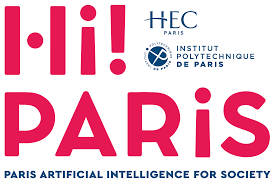</center>

___

<center>Notebook provided by:</center>

[<center>Marylou Gabrié</center>](https://github.com/marylou-gabrie)
[<center>Gaëtan Brison</center>](https://github.com/gaetanbrison)
___

Supporting reference: 
* A Practical Tutorial on Graph Neural Networks by Ward et al. (2020)
* graph neural networks part three, Lina Faik
* Pytorch Geometric
* Visuals from **deepfindr**

# First Application: Graph Classification

<center><img src="https://i.postimg.cc/rsXrpGMS/Screenshot-2022-11-08-at-13-40-51.png
" width=2000 height=500/></center>


## 00 - Introduction to Example

## i - Presentation of the dataset 

* Source: The dataset comes from MoleculeNet (Tox-21) with node and edge enrichment introduced by the Open Graph Benchmark.
* Description: The dataset used contains 7 831 molecules. Each molecule is converted into a graph by representing atoms by nodes and replacing the bonds by edges. These nodes and edges are further enriched with various features to avoid losing valuable information such as the name of the atom or the type of bond. In total, input node features are 9-dimensional and edge features 3-dimensional.
* Task: Predict whether a molecule is toxic or not.

What are the node features?

* Atomic number: Number of protons in the nucleus of an atom. It’s characteristic of a chemical element and determines its place in the periodic table.

* Chirality: A molecule is chiral if it is distinguishable from its mirror image by any combination of rotations, translations, and some conformational changes. Different types of chirality exist depending on the molecule and the arrangement of the atoms.

* Degree: Number of directly-bonded neighbors of the atom.

* Formal charge: Charge assigned to an atom. It reflects the electron count associated with the atom compared to the isolated neutral atom.

* Number of H: Total number of hydrogen atoms on the atom.

* Number of radical e: Number of unpaired electrons of the atom.

* Hybridization: Atom’s hybridization.

* Is aromatic: Whether it is included in a cyclic structure with pi bonds. This type of structure tends to be very stable in comparison with other geometric arrangements of the same atoms.

* Is in ring: Whether it is included in a ring (a simple cycle of atoms and bonds in a molecule).

Edge features:

* Bond type: Whether the bond is single, double, triple, or aromatic.
* Stereo configuration of the bond.
* Is conjugated: Whether or not the bond is considered to be conjugated.

## 01 - Import of Libraries

 To run the following code it is advised to run it on GPU execution mode

In [ ]:


import os
import torch
os.environ['TORCH'] = '1.12.1+cu113'
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install  py3Dmol rdkit  --quiet

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 5.7 MB/s 
     |████████████████████████████████| 3.5 MB 5.0 MB/s 
     |████████████████████████████████| 29.5 MB 1.2 MB/s 


In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import libraries

## Basics libraries
import pandas as pd, numpy as np
from itertools import product
import io, os, json
import time

## Molecules related libraries
import py3Dmol
from rdkit import Chem

## Visualization libraries
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = "plotly_white"
%matplotlib inline

## Models libraries
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit

##Models libraries for graph machine learning
import torch_geometric.transforms as T
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import to_hetero
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear

## Data libraries
from torch_geometric.data import InMemoryDataset, download_url, extract_gz
from torch_geometric.datasets import MoleculeNet



## 02 - Explore Data & Process Data

The dataset contains the outcomes of 12 different toxicological experiments in the form of binary labels (active/inactive).

The data, as it is, poses two main challenges:

* Small dataset: The number of labeled molecules varies depending on the experiment.
* Unbalanced targets: The percentage of active molecules is very low, up to 3% as shown in the figure below.

<center><img src="https://i.postimg.cc/XN5VV2bq/Screenshot-2022-11-08-at-07-55-17.png
" width=900 height=300/></center>




In [ ]:
dataset = MoleculeNet('MoleculeNet', "Tox21")

Extracting MoleculeNet/tox21/raw/tox21.csv.gz
Processing...
Done!


In [ ]:
dataset

Tox21(7831)

In [ ]:
def draw_molecule(mol):
    
    m = Chem.MolToMolBlock(mol,confId=-1)
    
    p = py3Dmol.view(width=400,height=400)
    p.removeAllModels()
    
    p.addModel(m,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    
    return p.show()

In [ ]:

i = 3666 # np.random.randint(len(dataset)) 
m = Chem.MolFromSmiles(dataset[i].smiles)

In [ ]:
i

3666

In [ ]:
data = dataset[i]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[17, 9], edge_index=[2, 36], edge_attr=[36, 3], smiles='Nc1cccc(S(=O)(=O)c2cccc(N)c2)c1', y=[1, 12])
Number of nodes: 17
Number of edges: 36
Average node degree: 2.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
draw_molecule(m)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
for i in range(len(dataset)):
    x_i = dataset[i].x.cpu().detach().numpy()
    x = x_i if i ==0 else np.vstack([x,dataset[i].x.cpu().detach().numpy()])
    
    y_i = dataset[i].y.cpu().detach().numpy()
    y = y_i if i ==0 else np.vstack([y,dataset[i].y.cpu().detach().numpy()])
    
df_x = pd.DataFrame(x)

In [ ]:
df_x.columns = [
    'atomic_num', 'chirality', 'degree', 'formal_charge', 
    'numH', 'number_radical_e', 'hybridization', 
    'is_aromatic', 'is_in_ring'
]

In [ ]:
df_x.head(10)

,atomic_num,chirality,degree,formal_charge,numH,number_radical_e,hybridization,is_aromatic,is_in_ring
0,6,0,4,5,3,0,4,0,0
1,6,0,4,5,2,0,4,0,0
2,8,0,2,5,0,0,3,0,0
3,6,0,3,5,0,0,3,1,1
4,6,0,3,5,1,0,3,1,1
5,6,0,3,5,1,0,3,1,1
6,6,0,3,5,0,0,3,1,1
7,7,0,2,5,0,0,3,1,1
8,6,0,3,5,0,0,3,1,1
9,16,0,4,5,0,0,4,0,0


In [ ]:
for col in df_x:
    px.histogram(
        df_x, col, histnorm='percent',
        height=300, width=500, title='Distribution of '+col).show()

In [ ]:
cols_to_normalize = [
    'atomic_num', 'degree', 
    'formal_charge', 
    'numH',  
    'number_radical_e'
]
cols_to_encode = [
    'chirality',
    'hybridization'
]

In [ ]:
METHOD = 'min-max'

scalers = {}

for c in cols_to_normalize + cols_to_encode:
    if METHOD == 'normal':
        scalers[c] = {'mean':df_x[c].mean(), 'std':df_x[c].std()}
    if METHOD == 'min-max':
        scalers[c] = {'min': df_x[c].min(), 'max': df_x[c].max()}

In [ ]:
scalers

{'atomic_num': {'min': 1, 'max': 83},
 'degree': {'min': 0, 'max': 6},
 'formal_charge': {'min': 3, 'max': 8},
 'numH': {'min': 0, 'max': 6},
 'number_radical_e': {'min': 0, 'max': 1},
 'chirality': {'min': 0, 'max': 2},
 'hybridization': {'min': 0, 'max': 6},
 'bond_type': {'min': 1, 'max': 4}}

In [ ]:
scalers['bond_type'] = {'min': 1, 'max': 4}

In [ ]:
data.y

tensor([[0., 0., 1., nan, 0., 0., 0., nan, 0., nan, nan, 0.]])

In [ ]:
dataset_new = []

for i in range(len(dataset)):
    data = dataset[i]
    x_norm = data.x.detach().cpu().numpy().astype(float)
    edge_w_norm = data.edge_attr[:,0].detach().cpu().numpy().astype(float)
    edge_a_norm = data.edge_attr[:,0].detach().cpu().numpy().astype(int)
    
    # normalize columns
    for c in cols_to_normalize:
        col_i = list(df_x.columns).index(c)
        
        if METHOD == 'normal':
            x_norm[:, col_i] = (x_norm[:, col_i] - scalers[c]['mean'])/scalers[c]['std']
        if METHOD == 'min-max':
            x_norm[:, col_i] = (x_norm[:, col_i] - scalers[c]['min'])/(scalers[c]['max'] - scalers[c]['min'])
    
    # one-hot encoding of categorical columns
    for i,c in enumerate(cols_to_encode):
    
        col = x_norm[:,list(df_x.columns).index(c)].astype(int)
        col_enc = np.zeros((col.size, scalers[c]['max']+1))
        col_enc[np.arange(col.size),col] = 1

        cols_encoded = col_enc if i == 0 else np.hstack([cols_encoded, col_enc])

    cols_i_to_encode = [list(df_x.columns).index(c) for c in cols_to_encode] 
    x_norm = x_norm[:,[i for i in range(x_norm.shape[1]) if i not in cols_i_to_encode]]
    x_norm = np.hstack([x_norm, cols_encoded])
    
    # normalize type of bonds
    edge_w_norm = (edge_w_norm - scalers['bond_type']['min'])/(scalers['bond_type']['max'] - scalers['bond_type']['min'])
    
    # one-hot encoding of type of bonds
    edge_a_norm = data.edge_attr[:,0].detach().cpu().numpy().astype(int)
    col_enc = np.zeros((edge_a_norm.size, scalers['bond_type']['max']+1))
    col_enc[np.arange(edge_a_norm.size),edge_a_norm] = 1
    
    # saving results
    data.x_norm = torch.tensor(x_norm, dtype=torch.float)
    data.edge_w_norm = torch.tensor(edge_w_norm, dtype=torch.float)
    data.edge_a_norm = torch.tensor(col_enc, dtype=torch.float)
    
    dataset_new.append(data)

In [ ]:
df_y = pd.DataFrame(y).melt()

In [ ]:
df_y1 = df_y.groupby(['variable'],as_index=False).agg({'value':['sum', 'count']})
df_y1.columns = ['variable','sum', 'count']
df_y1['mean'] = df_y1['sum']/df_y1['count']
df_y1['missing_values'] = (1 - df_y1['count'] / len(dataset))

In [ ]:

for c in ['mean', 'missing_values']:
    df_y1[c] = df_y1[c].apply(lambda x:round(x*100,2))

In [ ]:
df_y1.shape

(12, 5)

In [ ]:
df_y.head(3)

,variable,value
0,0,0.0
1,0,0.0
2,0,NaN


In [ ]:
df_y1

,variable,sum,count,mean,missing_values
0,0,309.0,7265,4.25,7.23
1,1,237.0,6758,3.51,13.70
2,2,768.0,6549,11.73,16.37
3,3,300.0,5821,5.15,25.67
4,4,793.0,6193,12.80,20.92
5,5,350.0,6955,5.03,11.19
6,6,186.0,6450,2.88,17.64
7,7,942.0,5832,16.15,25.53
8,8,264.0,7072,3.73,9.69
9,9,372.0,6467,5.75,17.42


In [ ]:
TARGET = 2

replace missing values

In [ ]:
dataset_target, Y = [], []

for i in range(len(dataset_new)):
    if not(dataset_new[i]['y'][0,TARGET].isnan()):
        Y.append(dataset_new[i]['y'][0,TARGET])
        dataset_target.append(dataset_new[i])
        
Y = pd.DataFrame([y.numpy() for y in Y]).reset_index().rename(columns={0:'target'})

In [ ]:
Y.target.mean()*100

11.726981401443481

In [ ]:
class_weights = torch.tensor([Y.target.mean(), 1-Y.target.mean()])
class_weights = class_weights.to(torch.float)
class_weights.dtype

torch.float32

In [ ]:
def split_dataset(dataset_target, Y, test_size=0.25, random_state=None):
    random_state = np.random.randint(10**3) if random_state is None else random_state
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state = random_state)

    train_dataset, test_dataset = [], []
    for train_index, test_index in sss.split(Y['index'], Y['target']):
        train_dataset += [dataset_target[i] for i in list(train_index)]
        test_dataset += [dataset_target[i] for i in list(test_index)]

    print(f'Number of training graphs: {len(train_dataset)} -> {round(len(train_dataset)/len(dataset_target)*100)}%')
    print(f'Number of test graphs: {len(test_dataset)} -> {round(len(test_dataset)/len(dataset_target)*100)}%')
    
    return train_dataset, test_dataset 

In [ ]:
train_dataset, test_dataset = split_dataset(dataset_target, Y)

Number of training graphs: 4911 -> 75%
Number of test graphs: 1638 -> 25%


Importance of using DataLoader to process in batch 

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=120)
test_loader = DataLoader(test_dataset, batch_size=120)

## 03 Model


Model Architecture
The model learns to classify graphs using three main steps:

* Embed nodes using several rounds of message passing.
* Aggregate these node embeddings into a single graph embedding (called readout layer). In the code below, the average of node embeddings is used (global mean pool).
* Train a classifier based on graph embeddings.





<center><img src="https://i.postimg.cc/tTYwxVKD/Screenshot-2022-11-07-at-22-15-33-removebg-preview.png
" width=1100 height=100/></center>




<center><img src="https://i.postimg.cc/7LcXjtRM/Screenshot-2022-11-07-at-21-04-36-removebg-preview.png
" width=1100 height=300/></center>


Building a Graph Neural Network works the same way as building a Convolutional Neural Network, we simple add some layers.

The GCN simply extends torch.nn.Module.
GCNConv expects:
- in_channels = Size of each input sample.
- out_channels = Size of each output sample.

We apply three convolutional layers, which means we learn the information about 3 neighbor hops. After that we apply a pooling layer to combine the information of the individual nodes, as we want to perform graph-level prediction.

Always keep in mind that different learning problems (node, edge or graph prediction) require different GNN architectures.

For example for node-level prediction you will often encounter masks. For graph-level predictions on the other hand you need to combine the node embeddings.

In [ ]:
from torch.nn import Linear, Softmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv
#from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp


class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_channels, conv, conv_params={}):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = conv(
            input_size, hidden_channels, **conv_params)
        self.conv2 = conv(
            hidden_channels, hidden_channels, **conv_params)
        self.conv3 = conv(
            hidden_channels, hidden_channels, **conv_params)
        self.lin = Linear(hidden_channels*2, 2)

    def forward(self, x, edge_index, batch,  edge_col = None):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_col)

        # 2. Readout layer
        batch = torch.zeros(data.x.shape[0],dtype=int) if batch is None else batch
        x = torch.cat([gmp(x, batch), 
                            gap(x, batch)], dim=1)
        #x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x

model = GNN(input_size = 17, hidden_channels=64, conv = GCNConv)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GNN(
  (conv1): GCNConv(17, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)
Number of parameters:  9730


### Number of Parameters

- We could also increase the embeddings, but as we have small molecules we use 32
- The more layers we add, the more information we get about the graph
- For the regression problem we use a Linear layer as final output layer
- We try to use not too many parameters, as we only have ~7k samples

### Layers


<center><img src="https://i.postimg.cc/c1fYy7LS/Screenshot-2022-11-07-at-20-55-14-removebg-preview-1.png
" width=1100 height=400/></center>

### Pooling 


<center><img src="https://i.postimg.cc/CKx3HtyF/Screenshot-2022-11-07-at-21-56-46-removebg-preview.png
" width=1100 height=400/></center>


### Number of Convolutions



We apply three convolutional layers, which means we learn the information about 3 neighbor hops. After that we apply a pooling layer to combine the information of the individual nodes, as we want to perform graph-level prediction.

### Loss

CrossEntropy: We can modify the this cross entropy loss function for class imbalance by incorporating class weights.

In [ ]:
def train(train_loader, model, target, optimizer, criterion, edge_col_name):
    model.train()
    
    losses = []
    
    for data in train_loader:  # Iterate in batches over the training dataset.
        
        if edge_col_name==None:
            out = model(data.x_norm, data.edge_index, data.batch) 
        else:
            out = model(data.x_norm, data.edge_index, data.batch, data[edge_col_name]) 
        
        loss = criterion(out, data.y[:,target].long())  # Compute the loss.
        # print("Train Passed")
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        losses.append(loss.cpu().detach().numpy())
        
    return np.mean(losses).astype(float)

def test(loader, model, target, edge_col_name, metric = metrics.accuracy_score):
    
    model.eval()
    
    score = 0
    for data in loader:
        if edge_col_name==None:
            out = model(data.x_norm, data.edge_index, data.batch) 
        else:
            out = model(data.x_norm, data.edge_index, data.batch, data[edge_col_name]) 
            
        y_pred = out.argmax(dim=1).detach().numpy()
        y_true = data.y[:,target].long().cpu().detach().numpy()
        
        score += metric(y_true, y_pred)
    
    return score/len(loader)

def train_test(
    train_loader, test_loader, model, model_params, target, class_weights, edge_col_name=None, 
    learning_rate=0.01, e_patience = 10, min_acc= 0.005, n_epochs=500):
    t0 = time.time()
    
    model = model(**model_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss(weight = class_weights)

    k=0
    
    loss, train_score, test_score = [], [], []
    
    for epoch in range(n_epochs):
        # print(f"Epoch {epoch} starts:")
        loss += [train(train_loader, model, target, optimizer, criterion, edge_col_name)]
        # print("loss Passed")
        train_score += [test(train_loader, model, target, edge_col_name)]
        # print("train_score Passed")
        test_score += [test(test_loader, model, target, edge_col_name)]
        # print("test_score Passed")
        
        if (epoch+1)%10==0:
            print(f'Epoch: {epoch+1:03d}, Loss: {loss[-1]:.4f}, Train: {train_score[-1]:.4f}, Test: {test_score[-1]:.4f}')

        results = pd.DataFrame({
            'loss': loss,
            'train_score': train_score, 'test_score': test_score,
            'time':(time.time()-t0)/60
        })

        # enable early stopping
        if (epoch > 1) and abs(loss[-1]/loss[-2]-1) < min_acc :
            k += 1
        if k> e_patience:
            print('Early stopping, epoch', epoch)
            break

    return model, results

def visualize_loss(results):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=results.index, y=results['train_score'], name = 'train_score'))
    fig.add_trace(go.Scatter(x=results.index, y=results['test_score'], name = 'test_score'))
    fig.add_trace(go.Scatter(x=results.index, y=results['loss'], name = 'loss'))

    fig.update_yaxes(title_text='Score')
    fig.update_xaxes(title_text="Epoch")
    
    fig.update_yaxes(range=[0,1.3*max([max(results[c]) for c in ['loss', 'train_score', 'test_score']])])
    

    return fig

## 04 Prediction

### Model 1 - GCNConv - N°layers 3 

In [ ]:
N_EPOCHS = 100    # For Testing: Actual 500
E_PATIENCE = 50
LEARNING_RATE = 0.01

In [ ]:
model_params = {"input_size":17, "hidden_channels":32, 'conv':GCNConv}

model, results = train_test(train_loader, test_loader, GNN, model_params, target = TARGET, class_weights = class_weights, learning_rate=LEARNING_RATE, e_patience = E_PATIENCE, n_epochs=N_EPOCHS)

Epoch: 010, Loss: 0.5303, Train: 0.5900, Test: 0.5711
Epoch: 020, Loss: 0.5191, Train: 0.5806, Test: 0.5583
Epoch: 030, Loss: 0.5030, Train: 0.6639, Test: 0.6481
Epoch: 040, Loss: 0.4962, Train: 0.6875, Test: 0.6683
Epoch: 050, Loss: 0.4885, Train: 0.6869, Test: 0.6639
Epoch: 060, Loss: 0.4816, Train: 0.7067, Test: 0.6886
Epoch: 070, Loss: 0.4726, Train: 0.7166, Test: 0.6919
Epoch: 080, Loss: 0.4641, Train: 0.7105, Test: 0.6892
Epoch: 090, Loss: 0.4589, Train: 0.7516, Test: 0.7310
Epoch: 100, Loss: 0.4628, Train: 0.7018, Test: 0.6833


In [ ]:
N = 3

In [ ]:
def train_test_CV(dataset_target, Y, GNN, model_params, target, 
                  class_weights,edge_col_name = None, 
                  learning_rate=0.01, e_patience = 10, min_acc= 0.005, n_epochs=500, N=1):

    for i in range(N):
        
        train_dataset, test_dataset = split_dataset(dataset_target, Y)

        train_loader = DataLoader(train_dataset, batch_size=120)
        test_loader = DataLoader(test_dataset, batch_size=120)
        
        model, results = train_test(
            train_loader, test_loader,
            GNN, model_params, target, class_weights, edge_col_name,
            learning_rate, e_patience, n_epochs = n_epochs)
        
        results_df = results.iloc[-1:] if i == 0 else pd.concat([results_df, results.iloc[-1:]])
        
        print(results_df)
        
    means = pd.DataFrame(results_df.mean()).T.rename(columns={c:c+'_mean' for c in results_df.columns})
    stds = pd.DataFrame(results_df.std()).T.rename(columns={c:c+'_std' for c in results_df.columns})
    results_df = pd.concat([means, stds], axis=1).reset_index(drop=True)
      
    return model, results_df

In [ ]:
model, results =  train_test_CV(
    dataset_target, Y, GNN, model_params, target = TARGET,
    class_weights = class_weights,edge_col_name=None,
    learning_rate=LEARNING_RATE, e_patience = E_PATIENCE, n_epochs=N_EPOCHS, N=3)

Number of training graphs: 4911 -> 75%
Number of test graphs: 1638 -> 25%
Epoch: 010, Loss: 0.5295, Train: 0.6470, Test: 0.6440
Epoch: 020, Loss: 0.5205, Train: 0.6494, Test: 0.6443
Epoch: 030, Loss: 0.5145, Train: 0.6484, Test: 0.6431
Epoch: 040, Loss: 0.5117, Train: 0.7104, Test: 0.7019
Epoch: 050, Loss: 0.5066, Train: 0.7253, Test: 0.7255
Epoch: 060, Loss: 0.4979, Train: 0.7161, Test: 0.7115
Epoch: 070, Loss: 0.5010, Train: 0.7548, Test: 0.7541
Epoch: 080, Loss: 0.4883, Train: 0.7156, Test: 0.7016
Epoch: 090, Loss: 0.4900, Train: 0.7491, Test: 0.7308
Epoch: 100, Loss: 0.4699, Train: 0.6978, Test: 0.6879
        loss  train_score  test_score      time
99  0.469928     0.697847    0.687912  2.014549
Number of training graphs: 4911 -> 75%
Number of test graphs: 1638 -> 25%
Epoch: 010, Loss: 0.5342, Train: 0.6634, Test: 0.6493
Epoch: 020, Loss: 0.5292, Train: 0.6868, Test: 0.6755
Epoch: 030, Loss: 0.5138, Train: 0.6967, Test: 0.6876
Epoch: 040, Loss: 0.5109, Train: 0.7269, Test: 0.7092


In [ ]:
results['model'] = 'GCNConv'
results_df = results
results_df

,loss,train_score,test_score,time,model
0,0.581275,0.521940,0.497253,2.515486,GCNConv
1,0.543980,0.588942,0.572619,2.515486,GCNConv
2,0.540224,0.609520,0.592903,2.515486,GCNConv
3,0.536216,0.599951,0.580952,2.515486,GCNConv
4,0.533872,0.573868,0.553251,2.515486,GCNConv
...,...,...,...,...,...
95,0.464214,0.783191,0.761951,2.515486,GCNConv
96,0.469946,0.660635,0.626374,2.515486,GCNConv
97,0.480580,0.634553,0.606639,2.515486,GCNConv
98,0.495515,0.642716,0.622161,2.515486,GCNConv


### Model (Optional) - Hyperparameters Tuning

In [ ]:
convs = [GATConv, GCNConv]
learning_rates = [0.01,0.001]
hidden_channels = [32, 64]
epochs = [50,100]
batches = [100,200]
n_layers = [3]
with_edge_data = [True, False]

In [ ]:
def run_grid_search_target(target, hidden_channels, convs, 
                           learning_rates, n_layers, with_edge_data,
                           random_state=0
                          ):
    dataset_target, Y = [], []

    for i in range(len(dataset_new)):
        if not(dataset_new[i]['y'][0,target].isnan()):
            Y.append(dataset_new[i]['y'][0,target])
            dataset_target.append(dataset_new[i])

    Y = pd.DataFrame([y.numpy() for y in Y]).reset_index().rename(columns={0:'target'})
    class_weights = torch.tensor([Y.target.mean(), 1-Y.target.mean()])
    train_dataset, test_dataset = split_dataset(dataset_target, Y)
    
    n_sc = len(hidden_channels)*len(learning_rates)*len(convs)*len(n_layers)*len(with_edge_data)

    i=0

    for hc, lr, c, n, ed in product(hidden_channels, learning_rates, convs, n_layers, with_edge_data):
        print()
        print('Sc: {}/{}'.format(i+1, n_sc))
        name_conv = str(c).split('.')[-1].replace('\'>', "")
        print({'hidden_channels':hc, 'learning_rate': lr, 
               'conv':name_conv, 'n_layers':n, 'with_edge_data': True})

        model_params = {"input_size":17, 'hidden_channels':hc, 'conv':c}
        
        algo = GNN if n == 2 else GNN_3l
        
        if not(ed):
            edge_col_name = None
            run_flag = True
        else:
            if name_conv == "GCNConv":
                edge_col_name = "edge_w_norm"
                run_flag = True
            elif name_conv == "GATConv":
                edge_col_name = "edge_a_norm"
                model_params['conv_params'] = {'edge_dim':5}
                run_flag = True
            else:
                run_flag = False
        
        if run_flag:
            
            model, results = train_test_CV(
                dataset_target, Y, algo, model_params, target = target, 
                class_weights = class_weights, edge_col_name = edge_col_name,
                learning_rate=lr, e_patience = E_PATIENCE, n_epochs=N_EPOCHS)

            results['model'] = name_conv
            results['hc'] = hc
            results['lr'] = lr
            results['n_layers'] = n
            results['with_edge_data'] = ed

            results_df = results if i==0 else pd.concat([results_df, results], axis=0)
            results_df.reset_index(drop=True, inplace=True)
            

            display(results_df)

            i+=1

    if i>0:
        results_df['target'] = target
        results_df['perc_class'] = Y.target.mean()
        cols = ['target', 'model', 'hc', 'lr']
        results_df = results_df[
            cols+[c for c in results_df.columns if c not in cols]
        ].sort_values(by='test_score_mean').reset_index(drop=True)

        return results_df

In [ ]:

results_target = run_grid_search_target(
    TARGET, hidden_channels, convs, learning_rates, n_layers, with_edge_data)

In [ ]:
for target in range(0,12):
    print('Target {}/{}'.format(target+1, 12))
    results_target = run_grid_search_target(
        target, hidden_channels, convs, learning_rates, n_layers, with_edge_data)
    results_all_targets = results_target if target == 0 else pd.concat([results_target, results_all_targets], axis=0)
    
    results_all_targets.reset_index(drop=True, inplace=True)
    
    display(results_all_targets)
    print('---'*10)

In [ ]:
tmp = results_all_targets.groupby(['target'],as_index=False).agg({
    'test_score_mean': max
})

In [ ]:
tmp2 = tmp.merge(results_all_targets,how='left', on = ['target', 'test_score_mean'])
tmp2 = tmp2.merge(df_y1[['variable', 'count', 'missing_values']].rename(columns = {'variable' : 'target'}), 
           on='target',how='left')
tmp2

## 05 Visualization

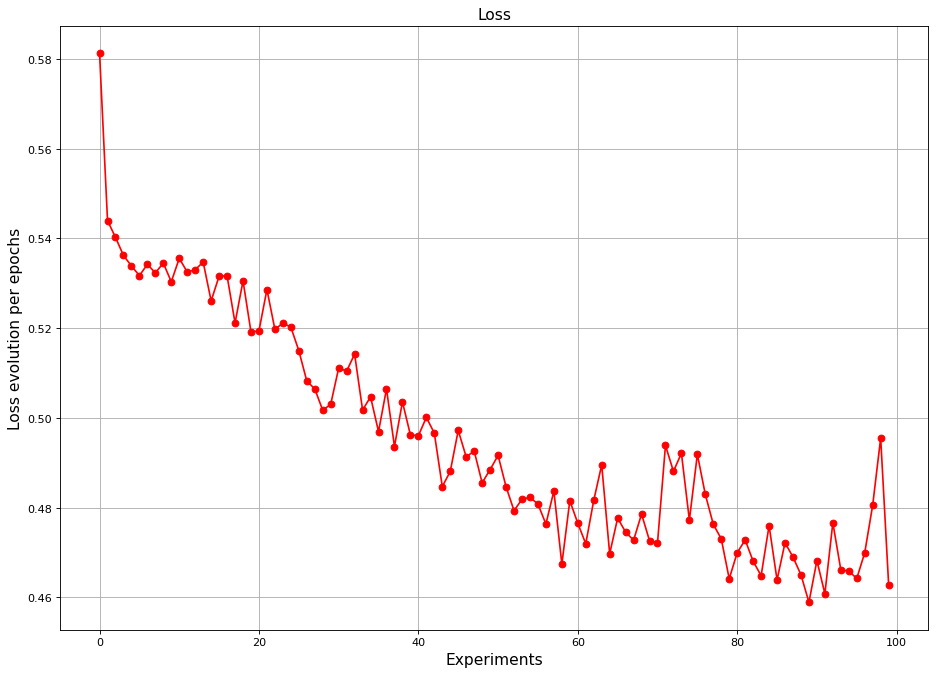

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(14, 10), dpi=80)
   
epochs = list(results_df.index)
loss_result = list(results_df["loss"])
  
plt.plot(epochs, loss_result, color='red', marker='o')
plt.title('Loss', fontsize=14)
plt.xlabel('Experiments', fontsize=14)
plt.ylabel('Loss evolution per epochs', fontsize=14)
plt.grid(True)
plt.show()

## 06 Explainability

In [ ]:
atoms = pd.read_csv(os.path.join(folder.get_path(),'atoms.csv'))
atoms.index = atoms.atomic_number
atoms = atoms['atom'].to_dict()

NameError: ignored

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.nn import GNNExplainer

from torch_geometric.utils import to_networkx

def draw_molecule(g, edge_index = None, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_mask_new = {}
        for i in range(edge_index.shape[1]):
            edge_mask_new[(edge_index[0][i], edge_index[1][i])] = edge_mask[i]
        edge_color = [edge_mask_new[(u, v)] for u, v in g.edges()]
        widths = [x * 3 for x in edge_color]
    
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.RdYlGn_r,
            node_color='pink')
    
    plt.show()
    
def to_molecule(data):
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = atoms[data['x'][0]]
        del data['x']
    return g

In [ ]:

graph_idx = np.random.randint(len(test_dataset))
data = test_dataset[graph_idx]

x, edge_index = data.x_norm, data.edge_index
explainer = GNNExplainer(model, epochs=300)
node_feat_mask, edge_mask = explainer.explain_graph(x, edge_index)

In [ ]:
node_feat_df = pd.DataFrame(node_feat_mask.cpu().detach().numpy(), columns=['feature'])
node_feat_df.index = [
    'atomic_num', 'chirality_0', 'chirality_1','chirality_2',
    'degree', 'formal_charge', 'numH', 'number_radical_e', 
    'hybridization_0', 'hybridization_1', 'hybridization_2', 
    'hybridization_3', 'hybridization_4', 'hybridization_5', 
    'hybridization_6','is_aromatic', 'is_in_ring'
]
node_feat_df.sort_values(by='feature',ascending=False)


<center><img src="https://i.postimg.cc/rFb4Xh2Q/Screenshot-2022-11-08-at-01-37-54.png
" width=300 height=900/></center>

## 06 Conclusion

#### Key Takeaways

✔ Graph Neural Networks, GNNs, can be used to classify entire graphs. The idea is similar to node classification or link prediction: learning an embedding of graphs (instead of nodes) using the structural properties of these graphs.

✔ When it comes to understanding the outcome of a model for a given instance, many approaches exist. They can rely on the gradient or features, use perturbation techniques, decompose the outcome, or use surrogate models.

✔ ️The real-life applications are multiple. This article was about the detection of the toxicity of molecules. Predicting other molecular properties lends itself well to this graph-based approach.

✔ ️However, biology is not the only industry. It can be used for instance in the retail industry: this article explains how GNNs can be applied to generate recommendations based on the graph of users’ sessions.

### Improvements


For example you can add:
- Dropouts
- Other (more intelligent) Pooling Layers (all layers here: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#)
- Global Pooling Layers
- Batch Normalization
- More MP layers
- Other hidden state sizes
- Test metrics (test error) and Hyperparameter optimization
- ...



What About Edge Features?
The type of bond that links two atoms in a given molecule holds valuable information about the molecule such as its stability, its reactivity, the presence of some chemically organic functional groups, etc. Therefore, including this feature has the potential to improve model performance.

But how can edge features be used when training the model?

If we take the example of GCN, it can easily be done by replacing the zeros and ones of the adjacency matrix with the edge weights. In this context, each message-passing iteration through the GCN updates the hidden embedding of nodes based on the aggregated and now weighted information of their neighborhood.



<center><img src="https://i.postimg.cc/cCJrn3wD/Screenshot-2022-11-08-at-02-14-22-removebg-preview.png
" width=900 height=900/></center>

## 07 References

References

[1] M.S. Attene-Ramos et al., Encyclopedia of Toxicology (Third Edition), 2014

[2] Pytorch Geometric tutorials, Graph Classification

[3] Tong Ying Shun, John S. Lazo, Elizabeth R. Sharlow, Paul A. Johnston, Identifying Actives from HTS Data Sets: Practical Approaches for the Selection of an Appropriate HTS Data-Processing Method and Quality Control Review. J. Biomol. Screen. 2010

[4] Evan N. Feinberg, et al, MoleculeNet: A Benchmark for Molecular Machine Learning, Zhenqin Wu, Bharath Ramsundar, March 2017

[5] Hao Yuan, Haiyang Yu, Shurui Gui, Shuiwang Ji, Explainability in Graph Neural Networks: A Taxonomic Survey, December 2020

[6] Rex Ying, Dylan Bourgeois, Jiaxuan You, Marinka Zitnik, Jure Leskovec, GNNExplainer: Generating Explanations for Graph Neural Networks, March 2019

[7] CS224W: Machine Learning with Graphs, Stanford

[8] graph-neural-networks-part-three, Lina Faik

[9] deepfindr.github.io for visuals 

## Congrats you made it 🚀

### Session 2/2 – Representation Learning on Large Graphs (To Come)
Tuesday 13 December, 2022 – 2.00-3.30pm (Online)
Speakers
* – Thomas Bonald, Telecom Paris
* – Simon Delarue, Hi! PARIS Phd @Télécom Paris
* – Tiphaine Viard, Telecom Paris

#### Program
The focus of this session will be on GraphSAGE, a Graph Neural Network (GNN) suitable for learning representations of large graphs. 
During the practical session, you will learn to classify articles of Wikipedia using both the textual content of the articles and the graph formed by the hyperlinks between articles.

#### Papers
– Inductive Representation Learning on Large Graphs by W.L. Hamilton, R. Ying, and J. Leskovec (2017)
